In [1]:
%load_ext autoreload
%autoreload 2

import os
import glob
from collections import defaultdict

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from infomap import Infomap

from analysis import *
from hypergraph.network import Tree, network_from_file

In [2]:
networks = read_filenames(glob.glob("output/*tree"))

match_ids(ground_truth_filename="multilayer_self_links", networks=networks)
write_networks(networks, "output/matched_ids")

summarize(networks)

,network,num states,num links,levels,top modules,codelength
0,bipartite,582,1561,2,29,4.62076
1,bipartite (non-bt),1142,3549,2,33,4.58282
2,clique (dir.),362,2247,2,34,4.40596
3,clique (dir. self links),362,2608,2,47,4.06513
4,multilayer,781,12844,2,40,4.31090
5,multilayer (self links),781,17194,2,46,4.06305
6,multilayer (similarity),781,12844,2,54,3.83458
7,multilayer (similarity self links),781,17194,2,55,3.74265


In [3]:
from os import path, remove

d = defaultdict(list)

ref_partition = Tree.from_file("ref_directed.ftree")
ref_partition_self_links = Tree.from_file("ref_directed_self_links.ftree")

two_level_ref_partition = Tree.from_file("output/clique_directed.ftree")
two_level_ref_partition_self_links = Tree.from_file("output/clique_directed_self_links.ftree")

for network in sorted(glob.glob("output/multilayer*_states.net"), key=len):
    d["filename"].append(" ".join(os.path.basename(network).split("_")[:-1]))

    self_links =  "self_links" in network
    ref = ref_partition_self_links if self_links else ref_partition
    
    cluster_data_tree = ref.cluster_data(network_from_file(network))
    
    temp_filename = path.basename(network) + ".tree"
    
    with open(temp_filename, "w") as temp_fp:
        for node in cluster_data_tree.nodes:
            node.write(temp_fp)

    include_self_links = "-k" if self_links else ""
    im = Infomap(f"-0 --silent --cluster-data {temp_filename} --directed {include_self_links}")
    im.read_file(network)
    im.run()
    
    os.remove(temp_filename)
    
    l1, t1, c1 = im.max_depth, im.num_top_modules, im.codelength

    two_level_ref = two_level_ref_partition_self_links if self_links else two_level_ref_partition
    
    basename = os.path.splitext(os.path.basename(network))[0]
    
    im = Infomap(f"-0 --silent --directed --no-infomap {include_self_links}")
    im.read_file(network)
    im.initial_partition = two_level_ref.initial_partition(network_from_file(network))
    im.run()
    im.write_tree(basename + "-no-infomap.tree", states=True)
    
    l2, t2, c2 = im.max_depth, im.num_top_modules, im.codelength

    im = Infomap(f"--silent -N100 -2 --directed {include_self_links}")
    im.read_file(network)
    im.run()
    im.write_tree(basename + "-optimized.tree", states=True)
    
    l3, t3, c3 = im.max_depth, im.num_top_modules, im.codelength

    d["levels (multilevel)"].append(l1)
    d["levels (2-level no-infomap)"].append(l2)
    d["levels (2-level optimized)"].append(l3)

    d["modules (multilevel)"].append(t1)
    d["modules (2-level no-infomap)"].append(t2)
    d["modules (2-level optimized)"].append(t3)

    d["L (multilevel)"].append(c1)
    d["L (2-level no-infomap)"].append(c2)
    d["L (2-level optimized)"].append(c3)
    

two_level_networks = read_filenames(glob.glob("*.tree"))
eff_ass = pd.concat(map(effective_assignments, two_level_networks), axis=1)
print(eff_ass.mean())

for tree in glob.glob("*.tree"):
    os.remove(tree)

pd.DataFrame(data=d)

multilayer (self links states-no-infomap)               1.000000
multilayer (self links states-optimized)                1.009791
multilayer (similarity self links states-no-infomap)    1.000000
multilayer (similarity self links states-optimized)     1.117055
multilayer (similarity states-no-infomap)               1.000000
multilayer (similarity states-optimized)                1.156810
multilayer (states-no-infomap)                          1.000000
multilayer (states-optimized)                           1.094787
dtype: float64


,filename,levels (multilevel),levels (2-level no-infomap),levels (2-level optimized),modules (multilevel),modules (2-level no-infomap),modules (2-level optimized),L (multilevel),L (2-level no-infomap),L (2-level optimized)
0,multilayer,4,2,2,6,34,43,4.244993,4.405958,4.305373
1,multilayer self links,4,2,2,9,47,47,3.833874,4.065128,4.060158
2,multilayer similarity,4,2,2,6,34,54,4.078923,4.245863,3.834584
3,multilayer similarity self links,4,2,2,9,47,57,3.693388,3.912162,3.742573


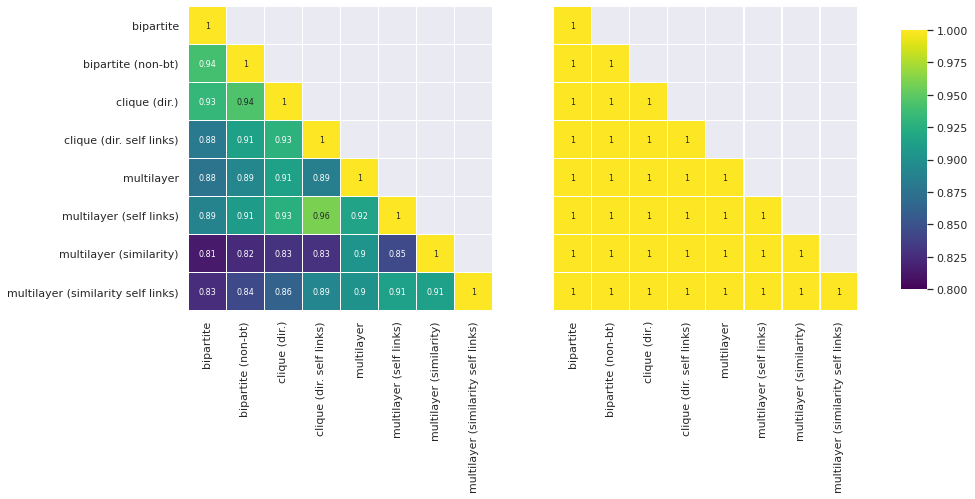

In [4]:
f, ax = plt.subplots(1, 2, figsize=(12,6))
cbar_ax = f.add_axes([0.95, 0.2, 0.03, 0.6])

ami_score = ami(networks)
jaccard_score = weighted_jaccard_dist(networks)

plot_heatmap(ami_score, ax=ax[0], cbar=False, yticklabels=ami_score.columns);
plot_heatmap(jaccard_score, ax=ax[1], cbar_ax=cbar_ax, yticklabels=False);

(multilayer                            1.096953
 multilayer (self links)               1.024931
 multilayer (similarity)               1.182825
 multilayer (similarity self links)    1.130194
 dtype: float64,
 multilayer                            1.083799
 multilayer (self links)               1.022726
 multilayer (similarity)               1.156810
 multilayer (similarity self links)    1.109483
 dtype: float64)

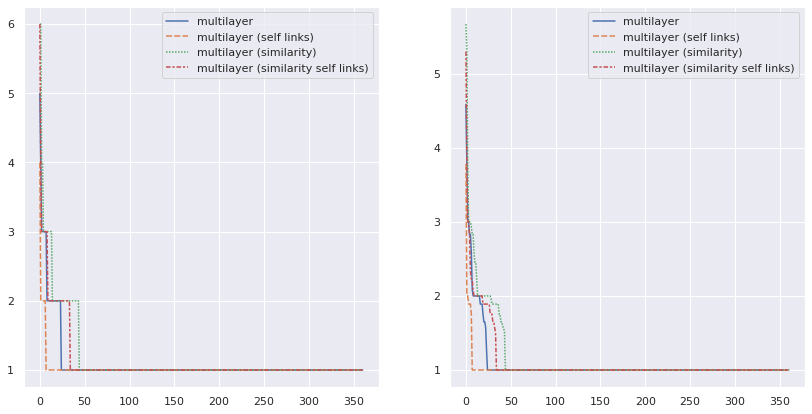

In [5]:
multilayer_networks = networks[-4:]

ass = pd.concat(map(assignments, multilayer_networks), axis=1)
eff_ass = pd.concat(map(effective_assignments, multilayer_networks), axis=1)

f, ax = plt.subplots(1, 2, figsize=(14,7))

sns.lineplot(data=ass, ax=ax[0])
sns.lineplot(data=eff_ass, ax=ax[1])

ass.mean(), eff_ass.mean()